 *需安装numpy，pandas，scipy，detecta，matplotlib.pyplot，sklearn*
### raw data读取与预处理
+ mid5是窗口为5的中值滤波
+ 小程序自身采样率已经不足20Hz，故在此省去低通滤波，低通滤波只用于提取重力加速度
+ 取窗口2s，print窗口信号个数

In [1]:
import numpy as np
import pandas as pd 
from scipy import signal


#中值滤波
def mid5(arr):
    arr=[0,0]+list(arr)+[0,0]
    output=[]
    # print(len(arr))
    for i in range(2,len(arr)-2):
        temp=list(arr[i-2:i+3])
        # print(temp)
        temp.sort()
        output.append(temp[2])
    # print(output)
    return np.array(output)


def prefilter(x):
    x=mid5(x)
    # b, a = signal.butter(3, 0.99, 'lowpass')    # changeable
    # x=signal.filtfilt(b, a, x)
    return np.array(x, dtype=np.float32)

def window(x,block):
    win=[]
    for i in range(block*2,len(x),block):
        win.append(np.array([j for j in x[i-block*2:i]]))
    return np.array(win)


def prepro(path,time):
    data = pd.read_csv(path)
    n,m=data.shape
    freq=n/time

    taccX=prefilter(data['accX'])
    taccY=prefilter(data['accY'])
    taccZ=prefilter(data['accZ'])
    gyrX=prefilter(data['geoX'])
    gyrY=prefilter(data['geoY'])
    gyrZ=prefilter(data['geoZ'])

    ctf=0.3
    # signal.butter(3,2*ctf/freq,'low')
    b, a = signal.butter(3, 2*ctf/freq, 'low')   # changeable
    baccX = np.array(signal.filtfilt(b, a, taccX))
    b, a = signal.butter(3, 2*ctf/freq, 'low')   # changeable
    baccY = np.array(signal.filtfilt(b, a, taccY))
    b, a = signal.butter(3, 2*ctf/freq, 'low')   # changeable
    baccZ = np.array(signal.filtfilt(b, a, taccZ))

    block=int(2*freq//2+1 )    # changeable
    # block=int(2*block)
    

    taccX=window(taccX,block)
    taccY=window(taccY,block)
    taccZ=window(taccZ,block)
    baccX=window(baccX,block)
    baccY=window(baccY,block)
    baccZ=window(baccZ,block)
    gyrX=window(gyrX,block)
    gyrY=window(gyrY,block)
    gyrZ=window(gyrZ,block)

    signals=[baccX,baccY,baccZ,gyrX,gyrY,gyrZ,taccX,taccY,taccZ]
    signals = np.transpose(np.array(signals), (1, 2, 0))

    label = window(data['label'], block)
    label = np.array([max(x, key=list(x).count) for x in label])

    return signals,label,2*block,freq,1/block


train_signals,train_labels,trN,trF_s,trT=prepro('./dataset/HARtrain480s.csv',480)
test_signals,test_labels,tsN,tsF_s,tsT=prepro('./dataset/HARtest80s.csv',80)
print(len(train_signals[0]))

38


### 特征提取与可视化
+ 分别用fft，psd，auto-correlation变换信号后再进行特征提取
+ 特征包括9个信号每种变换前5个峰值的x和y值(9\*3\*5*2)
+ 对同一窗口下的预处理信号及变换信号可视化
+ 根据可视化的观察选取某个动作合适的计数信号，即选取波峰显著周期明显的信号以进行波峰计数
+ 更改signal_no查看不同窗口的可视化结果

D:\software\Programming\anaconda\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 38, using nperseg = 38
  .format(nperseg, input_length))
D:\software\Programming\anaconda\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 38, using nperseg = 38
  .format(nperseg, input_length))
D:\software\Programming\anaconda\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 38, using nperseg = 38
  .format(nperseg, input_length))
D:\software\Programming\anaconda\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 38, using nperseg = 38
  .format(nperseg, input_length))
D:\software\Programming\anaconda\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 38, using nperseg = 38
  .format(nperseg, input_length))
D:\softwar

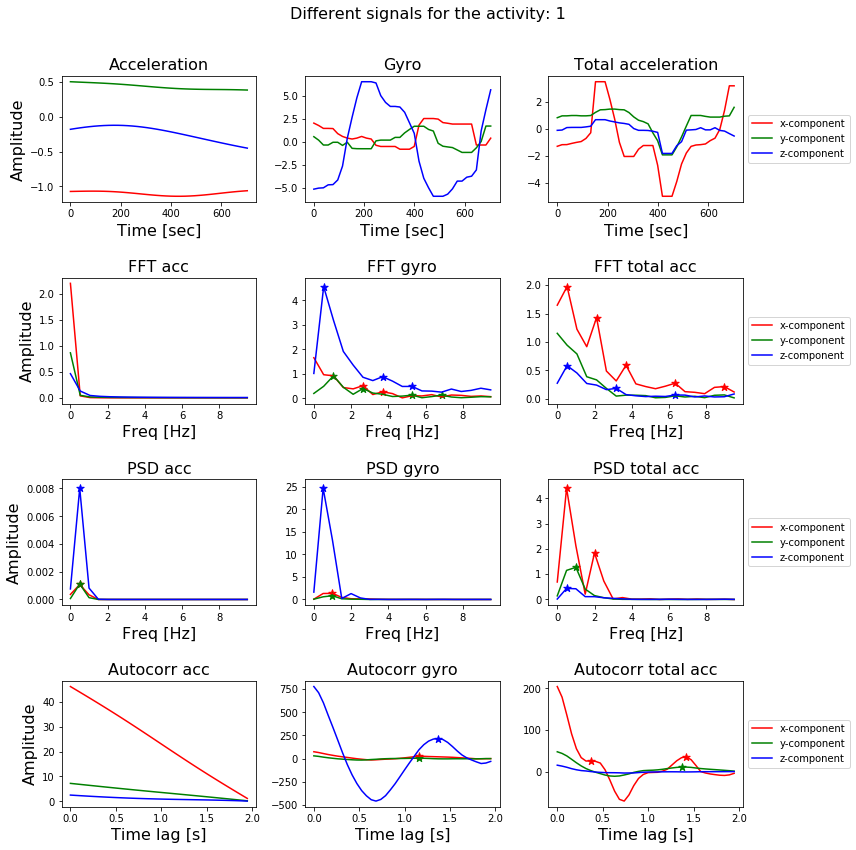

In [2]:
from scipy.fftpack import fft
from scipy.signal import welch
from detecta import detect_peaks
import matplotlib.pyplot as plt

signal_no = 136

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)    # 频值x
    fft_values_ = fft(y_values)
    fft_values = 2.0 / N * np.abs(fft_values_[0:N // 2])    # 幅值y
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values


def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result) // 2:]


def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values


def get_first_n_peaks(x, y, no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks - len(x_)
        return x_ + [0] * missing_no_peaks, y_ + [0] * missing_no_peaks


def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y


def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0, dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]

            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100 - percentile)
            # ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min) / denominator

            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)


def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [19 * kk for kk in range(0, len(y_values))]
    return x_values, y_values


####

labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"

xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
            ]
activities_description=['0','1','2','3']
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

N = 38
f_s = 19
t_n = 2
T = t_n / N

signals = train_signals[signal_no, :, :]
# print(signals.shape)
label = train_labels[signal_no]
activity_name = activities_description[label]
# activity_name =label
f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
f.suptitle(suptitle.format(activity_name), fontsize=16)

for row_no in range(0, 4):
    for comp_no in range(0, 9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]

        axtitle = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]

        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)

        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
            # print('peak freq',x_values[indices_peaks])
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()


### 模型训练与评估
+ 比较模型SVM，RF，朴素贝叶斯
+ 比较特征提取训练集与滤波6轴训练集
+ 发现3种模型2种训练集效果都很好
+ 最终选用较简单的朴素贝叶斯，滤波6轴训练集

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

def raw_data(path,time):
    data = pd.read_csv(path)
    n, m = data.shape
    freq = n / time
    # block = int(2 * freq // 2 + 1)
    block=19
    
    taccX=window(prefilter(data['accX']),block)
    taccY=window(prefilter(data['accY']),block)
    taccZ=window(prefilter(data['accZ']),block)
    gyrX=window(prefilter(data['geoX']),block)
    gyrY=window(prefilter(data['geoY']),block)
    gyrZ=window(prefilter(data['geoZ']),block)
    # print(taccX)
    signals=[]
    for i in range(len(taccX)):
        signals+=[list(taccX[i])+list(taccY[i])+list(taccZ[i])+list(gyrX[i])+list(gyrY[i])+list(gyrZ[i])]

    label = window(data['label'], block)
    label = np.array([max(x, key=list(x).count) for x in label])

    return np.array(signals), np.array(label)

denominator = 10    # changeable 'minimum peak height'
X_train, Y_train = extract_features_labels(train_signals, train_labels, trT, trN, trF_s, denominator)
X_test, Y_test = extract_features_labels(test_signals, test_labels, tsT, tsN, tsF_s, denominator)
X_trainR, Y_trainR = raw_data('HARtrain480s.csv',480)
X_testR, Y_testR =raw_data('HARtest80s.csv',80)
# print(X_train.shape)

stdScaler = StandardScaler().fit(X_train)
trainStd = stdScaler.transform(X_train)
testStd = stdScaler.transform(X_test)
svm = SVC().fit(trainStd,Y_train)
target_pred = svm.predict(testStd)
print('特征提取SVM：','\n',
      classification_report(Y_test, target_pred))

stdScaler2 = StandardScaler().fit(X_trainR)
trainStd2 = stdScaler2.transform(X_trainR)
testStd2 = stdScaler2.transform(X_testR)
svm = SVC().fit(trainStd2,Y_trainR)
target_pred2 = svm.predict(testStd2)
print('滤波6轴SVM：','\n',
      classification_report(Y_testR, target_pred2))

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, Y_train)
print('特征提取RF：')
# print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
# print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

clf2 = RandomForestClassifier(n_estimators=1000)
clf2.fit(X_trainR, Y_trainR)
print('滤波6轴RF：')
# print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
# print("Accuracy on test set is : {}".format(clf2.score(X_testR, Y_testR)))
Y_test_pred2 = clf2.predict(X_testR)
print(classification_report(Y_testR, Y_test_pred2))

clf = GaussianNB()
clf.fit(X_train, Y_train)
Y_test_pred = clf.predict(X_test)
print('特征提取bayes：')
print(classification_report(Y_test, Y_test_pred))

clf2 = GaussianNB()
clf2.fit(X_trainR, Y_trainR)
Y_test_pred = clf2.predict(X_testR)
print('滤波6轴bayes：')
print(classification_report(Y_testR, Y_test_pred))


D:\software\Programming\anaconda\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 38, using nperseg = 38
  .format(nperseg, input_length))
D:\software\Programming\anaconda\lib\site-packages\scipy\signal\spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 36, using nperseg = 36
  .format(nperseg, input_length))


特征提取SVM： 
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.76      1.00      0.86        19
           2       1.00      0.94      0.97        18
           3       1.00      0.82      0.90        17

    accuracy                           0.92        74
   macro avg       0.94      0.92      0.92        74
weighted avg       0.94      0.92      0.92        74

滤波6轴SVM： 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        16

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70

特征提取RF：
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  

复现模型

In [5]:
from math import sqrt
from math import exp

def separate_by_class(dataset):
    separated = dict()
    for i in range(len(dataset)):
        vector = dataset[i]
        class_value = vector[-1]
        if (class_value not in separated):
            separated[class_value] = list()
        separated[class_value].append(vector)
    # print('s',len(separated[0]))
    return separated

def mean(numbers):
    return sum(numbers)/float(len(numbers))

def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)

def summarize_dataset(dataset):
    summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
    del(summaries[-1])
    # print(summaries)
    return summaries

def summarize_by_class(dataset):
    separated = separate_by_class(dataset)
    summaries = dict()
    for class_value, rows in separated.items():
        summaries[class_value] = summarize_dataset(rows)
    # print(summaries)
    return summaries

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def calculate_probability(x,mean,stdev):
    exponent = exp(-((x-mean)*(x-mean) / (2 * stdev*stdev )))
    return (1 / (sqrt(2 * 3.14159265) * stdev)) * exponent

def predict(summaries,row):
    probability,max_pro=0,0
    for i in range(4):
        probability=1/4
        for j in range(len(row)):
            probability=probability*calculate_probability(row[j],summaries[i][j][0],summaries[i][j][1])
        # print(probability,max_pro)
        if(probability>max_pro):
            max_pro=probability
            label=i
    # print(label)
    return label


trainframe = pd.DataFrame(X_trainR)
trainframe['228']=Y_trainR
trainset=trainframe.values
summarize=summarize_by_class(trainset)
predictions = list()
actual=list()
for i in range(len(Y_testR)):
    output = predict(summarize, X_testR[i])
    predictions.append(output)
    actual.append(Y_testR[i])
    # print(output,Y_test[i])

accuracy = accuracy_metric(actual, predictions)
print('滤波6轴bayes：')
print('Accuracy on test set is :',accuracy)

# print('\nsumarize',summarize)


滤波6轴bayes：
Accuracy on test set is : 97.14285714285714
